In [4]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax
from turtle import forward

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [5]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"
config.model.reference_process_key = "ula"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "ion")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais"  or config.model.reference_process_key == "ula":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 1.0
    config.trainer.learning_rate = 1 * 10**(-5)
    
    if config.task == "funnel": # lnZ: 0.4, ELBO: 1.6
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.learning_rate = 1 * 10**(-5)
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar": # lnZ: -109.1, ELBO: -114.76
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    
    if config.task == "ion":     # lnZ: -112.275, ELBO: -117.619
        config.model.sigma = 0.5
        config.model.sigma_base = 0.7
    
    if config.task == "lgcp":  # lnZ: 473, ELBO: 413
        config.model.sigma = 4.6
        config.model.sigma_base = 2.3
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
# config.trainer.learning_rate = 5 * 10**(-3)

# config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 2000
# config.trainer.epochs = 1
config.model.sigma, config.model.sigma_base

(0.5, 0.7)

In [ ]:
def mfvi_init(
    config=config,
    sigma_init=config.model.sigma_base,
    dim=config.model.input_dim,
    target=config.model.target
):
    device_no = jax.device_count()
    batch_size_ = config.model.batch_size / device_no
    start = 0
    seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42
    lnpi = config.trainer.lnpi
    
    seq = hk.PRNGSequence(seed)
    rng_key = next(seq)
    subkeys = utils.bcast_local_devices(rng_key)

    def _forward_fn_mfvi(batch_size: int) -> jnp.ndarray:

        mus = hk.get_parameter(
          name="mus",
          shape=(dim,),
          init=hk.initializers.Constant(0.)
        )

        sigmas = hk.get_parameter(
          name="sigmas",
          shape=(dim,),
          init=hk.initializers.Constant(0.)
        )

        init_dist = distrax.MultivariateNormalDiag(
            mus ,
            sigmas
        )
        return init_dist.sample(
            seed=rng_key, sample_shape=batch_size), init_dist.entropy()

    forward_fn_mfvi = hk.transform_with_state(_forward_fn_mfvi) 
    
    p_init_fn_mfvi = jax.pmap(
        functools.partial(forward_fn_mfvi.init, batch_size=batch_size_,),
        axis_name="num_devices")

    params, model_state = p_init_fn_mfvi(subkeys)


    clipper = optax.clip(1.0)
    base_dec = config.trainer.lr_sch_base_dec
    scale_by_adam = optax.scale_by_adam()

    transition_steps = 50
    exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                    transition_steps, base_dec)
    scale_lr = optax.scale_by_schedule(exp_lr)
    opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

    opt_state = jax.pmap(opt.init)(params)
    
    
    def full_objective_mfvi(
        params,
        model_state: hk.State,
        rng_key: jnp.ndarray,
        batch_size: int
    ):
        
        (X, entropy), model_state = forward_fn_mfvi.apply(
          params, model_state, rng_key, batch_size
        )
        
        cross_ent = -lnpi(X).mean()

        loss = cross_ent - entropy
        return loss, model_state
    
    @functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4,))
    def update_mfvi(
        params,
        model_state: hk.State,
        opt_state: Any,
        rng_key: jnp.ndarray,
        batch_size: jnp.ndarray):

      grads, new_model_state = jax.grad(
          full_objective_mfvi, has_aux=True)(
              params,
              model_state,
              rng_key,
              batch_size)
      grads = jax.lax.pmean(grads, axis_name="num_devices")

      updates, opt_state = opt.update(grads, opt_state)
      new_params = optax.apply_updates(params, updates)
      return new_params, opt_state, new_model_state

    @functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3,))
    def jited_val_loss_mfvi(
        params,
        model_state: hk.State,
        rng_key: jnp.ndarray,
        batch_size: jnp.ndarray):

      loss, new_model_state = full_objective_mfvi(params,
                                             model_state,
                                             rng_key,
                                             batch_size_)

      loss = jax.lax.pmean(loss, axis_name="num_devices")
      return loss, new_model_state
    

    for epoch in range(start, config.trainer.epochs):
        rng_key = next(seq)
        subkeys = jax.random.split(rng_key, device_no)

        params, opt_state, model_state = update_mfvi(params,
                                                     model_state, opt_state,
                                                     subkeys, batch_size_)
        loss, _ = jited_val_loss_mfvi(params,
                                     model_state,
                                    subkeys, batch_size_)
        print(epoch, loss.item())
    
    init_dist = distrax.MultivariateNormalDiag(
            params["~"]["mus"] ,
            params["~"]["sigmas"]
    )
    return init_dist

init_dist = mfvi_init()

0 628.735595703125
1 604.4651489257812
2 590.263427734375
3 580.1840209960938
4 572.3634033203125
5 565.9716186523438
6 560.565673828125
7 555.8814697265625
8 551.7484741210938
9 548.05029296875
10 544.7037353515625
11 541.6477661132812
12 538.835693359375
13 536.231201171875
14 533.805908203125
15 531.5364379882812
16 529.4039306640625
17 527.392822265625
18 525.4898681640625
19 523.6839599609375
20 521.9656982421875
21 520.326904296875
22 518.7604370117188
23 517.2603149414062
24 515.8209228515625
25 514.4376220703125
26 513.1060791015625
27 511.8226013183594
28 510.5837707519531
29 509.3865966796875
30 508.2283630371094
31 507.1065673828125
32 506.0189514160156
33 504.9635009765625
34 503.9383850097656
35 502.9417724609375
36 501.97222900390625
37 501.02825927734375
38 500.1085205078125
39 499.2118225097656
40 498.33697509765625
41 497.4830017089844
42 496.6488037109375
43 495.8335876464844
44 495.0364685058594
45 494.2566223144531
46 493.49334716796875
47 492.7458801269531
48 492.0

382 416.581298828125
383 416.47991943359375
384 416.378662109375
385 416.2777099609375
386 416.1769714355469
387 416.0765075683594
388 415.9762268066406
389 415.876220703125
390 415.77642822265625
391 415.6768798828125
392 415.5775451660156
393 415.47845458984375
394 415.3795166015625
395 415.2809143066406
396 415.1824645996094
397 415.0842590332031
398 414.98626708984375
399 414.8885192871094
400 414.79095458984375
401 414.69366455078125
402 414.5965270996094
403 414.4996337890625
404 414.4029846191406
405 414.3065185546875
406 414.21026611328125
407 414.1142272949219
408 414.0184020996094
409 413.9228210449219
410 413.827392578125
411 413.73223876953125
412 413.6372375488281
413 413.54248046875
414 413.4478759765625
415 413.3534851074219
416 413.25933837890625
417 413.16534423828125
418 413.07159423828125
419 412.97802734375
420 412.8846740722656
421 412.79150390625
422 412.6985168457031
423 412.6058044433594
424 412.5132141113281
425 412.4208068847656
426 412.3286437988281
427 412.2

760 388.7908630371094
761 388.7351989746094
762 388.6795959472656
763 388.6239929199219
764 388.56854248046875
765 388.5130920410156
766 388.45770263671875
767 388.40240478515625
768 388.34716796875
769 388.2919616699219
770 388.23681640625
771 388.1817626953125
772 388.1267395019531
773 388.07177734375
774 388.0168762207031
775 387.9620666503906
776 387.90728759765625
777 387.85260009765625
778 387.79791259765625
779 387.74334716796875
780 387.68878173828125
781 387.63427734375
782 387.5798645019531
783 387.5254821777344
784 387.4712219238281
785 387.41693115234375
786 387.36279296875
787 387.3086242675781
788 387.25457763671875
789 387.2005310058594
790 387.1466064453125
791 387.09271240234375
792 387.038818359375
793 386.98504638671875
794 386.93133544921875
795 386.8776550292969
796 386.8240051269531
797 386.7704772949219
798 386.71697998046875
799 386.6635437011719
800 386.6101379394531
801 386.5567932128906
802 386.5035095214844
803 386.4503173828125
804 386.3971252441406
805 386

1302 364.8744812011719
1303 364.83856201171875
1304 364.8026123046875
1305 364.7667541503906
1306 364.73089599609375
1307 364.69500732421875
1308 364.6592102050781
1309 364.6233825683594
1310 364.5876159667969
1311 364.5518493652344
1312 364.51611328125
1313 364.48040771484375
1314 364.4447021484375
1315 364.4090576171875
1316 364.3733825683594
1317 364.3377990722656
1318 364.3021545410156
1319 364.2665710449219
1320 364.23101806640625
1321 364.1954650878906
1322 364.1599426269531
1323 364.1244201660156
1324 364.0889587402344
1325 364.0534973144531
1326 364.01806640625
1327 363.9826354980469
1328 363.9472351074219
1329 363.911865234375
1330 363.87646484375
1331 363.8411560058594
1332 363.8058776855469
1333 363.77056884765625
1334 363.73529052734375
1335 363.70001220703125
1336 363.6648254394531
1337 363.629638671875
1338 363.59442138671875
1339 363.55926513671875
1340 363.52410888671875
1341 363.4889831542969
1342 363.453857421875
1343 363.4187927246094
1344 363.3836975097656
1345 363.

1675 352.7563781738281
1676 352.7268371582031
1677 352.69732666015625
1678 352.6678161621094
1679 352.6383361816406
1680 352.6088562011719
1681 352.5793762207031
1682 352.5499267578125
1683 352.5205078125
1684 352.49102783203125
1685 352.461669921875
1686 352.4322509765625
1687 352.40289306640625
1688 352.37353515625
1689 352.3441467285156
1690 352.3148498535156
1691 352.2854919433594
1692 352.2561950683594
1693 352.2268981933594
1694 352.19757080078125
1695 352.1683349609375
1696 352.13909912109375
1697 352.10980224609375
1698 352.0805969238281
1699 352.0513610839844
1700 352.02215576171875
1701 351.9929504394531
1702 351.9637756347656
1703 351.9346008300781
1704 351.9054260253906
1705 351.8763427734375
1706 351.8471374511719
1707 351.8180847167969
1708 351.7889709472656
1709 351.7598876953125
1710 351.7308044433594
1711 351.7017822265625
1712 351.67266845703125
1713 351.6436462402344
1714 351.6146240234375
1715 351.5856018066406
1716 351.55657958984375
1717 351.5276184082031
1718 351

In [4]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [5]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f15e853a950>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f15e853ab00>)


In [6]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [7]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

print("TRAINING COMPLETED")
loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 206.39439392089844)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 206.3941192626953)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 208.65814208984375)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 209.9676055908203)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 200.20074462890625)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 202.05618286132812)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 205.47747802734375)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 201.8157501220703)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 213.9580841064453)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 218.14727783203125)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 207.42115783691406)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 207.0272674560547)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 212.2946014404297)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 207.65496826171875)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 206.1977996826172)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 217.89874267578125)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 206.0645904541015

('epoch: %s %s  loss: %s', 138, 'TRAIN', 217.1409912109375)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 194.16880798339844)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 209.23818969726562)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 200.3041229248047)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 208.971435546875)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 208.243408203125)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 206.73184204101562)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 202.727783203125)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 200.28062438964844)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 221.76625061035156)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 199.28990173339844)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 214.55699157714844)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 214.97119140625)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 210.22726440429688)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 204.8924560546875)
('epoch: %s %s  loss: %s', 153, 'TRAIN', 202.99044799804688)
('epoch: %s %s  loss: %s', 154, 'TRA

('epoch: %s %s  loss: %s', 276, 'TRAIN', 211.05921936035156)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 205.9196319580078)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 203.99505615234375)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 201.64013671875)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 197.9222412109375)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 210.04336547851562)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 214.5020751953125)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 210.67332458496094)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 211.33973693847656)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 203.93310546875)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 210.76705932617188)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 204.27581787109375)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 211.07936096191406)
('epoch: %s %s  loss: %s', 289, 'TRAIN', 208.064453125)
('epoch: %s %s  loss: %s', 290, 'TRAIN', 199.67172241210938)
('epoch: %s %s  loss: %s', 291, 'TRAIN', 199.4472198486328)
('epoch: %s %s  loss: %s', 292, 'TRAIN'

('epoch: %s %s  loss: %s', 414, 'TRAIN', 204.2403564453125)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 217.34877014160156)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 199.18370056152344)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 211.30201721191406)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 198.40011596679688)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 203.40284729003906)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 208.8177947998047)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 207.60049438476562)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 201.04733276367188)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 217.5450897216797)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 202.3538818359375)
('epoch: %s %s  loss: %s', 425, 'TRAIN', 217.8206787109375)
('epoch: %s %s  loss: %s', 426, 'TRAIN', 205.92938232421875)
('epoch: %s %s  loss: %s', 427, 'TRAIN', 208.95433044433594)
('epoch: %s %s  loss: %s', 428, 'TRAIN', 200.10800170898438)
('epoch: %s %s  loss: %s', 429, 'TRAIN', 202.9375)
('epoch: %s %s  loss: %s', 430, 'TRAIN'

('epoch: %s %s  loss: %s', 550, 'TRAIN', 201.14964294433594)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 211.2741241455078)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 211.62677001953125)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 202.6878204345703)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 208.63760375976562)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 205.76760864257812)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 211.68052673339844)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 201.49325561523438)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 204.8456573486328)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 211.34141540527344)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 210.2617645263672)
('epoch: %s %s  loss: %s', 561, 'TRAIN', 202.7609405517578)
('epoch: %s %s  loss: %s', 562, 'TRAIN', 208.9224853515625)
('epoch: %s %s  loss: %s', 563, 'TRAIN', 207.5852813720703)
('epoch: %s %s  loss: %s', 564, 'TRAIN', 204.51742553710938)
('epoch: %s %s  loss: %s', 565, 'TRAIN', 216.71041870117188)
('epoch: %s %s  loss: %s', 566,

('epoch: %s %s  loss: %s', 688, 'TRAIN', 207.49874877929688)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 210.63125610351562)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 209.9795684814453)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 208.34542846679688)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 197.3284149169922)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 209.99990844726562)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 207.05718994140625)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 200.43820190429688)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 207.53538513183594)
('epoch: %s %s  loss: %s', 697, 'TRAIN', 206.1890411376953)
('epoch: %s %s  loss: %s', 698, 'TRAIN', 213.683349609375)
('epoch: %s %s  loss: %s', 699, 'TRAIN', 194.2727813720703)
('epoch: %s %s  loss: %s', 700, 'TRAIN', 214.20497131347656)
('epoch: %s %s  loss: %s', 701, 'TRAIN', 201.79002380371094)
('epoch: %s %s  loss: %s', 702, 'TRAIN', 209.40023803710938)
('epoch: %s %s  loss: %s', 703, 'TRAIN', 206.3267822265625)
('epoch: %s %s  loss: %s', 704,

('epoch: %s %s  loss: %s', 824, 'TRAIN', 208.68875122070312)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 200.68670654296875)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 218.22279357910156)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 207.86151123046875)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 209.41896057128906)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 199.5974578857422)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 205.2550506591797)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 197.25082397460938)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 196.8909912109375)
('epoch: %s %s  loss: %s', 833, 'TRAIN', 209.61289978027344)
('epoch: %s %s  loss: %s', 834, 'TRAIN', 211.8777618408203)
('epoch: %s %s  loss: %s', 835, 'TRAIN', 202.9092254638672)
('epoch: %s %s  loss: %s', 836, 'TRAIN', 218.27500915527344)
('epoch: %s %s  loss: %s', 837, 'TRAIN', 209.50253295898438)
('epoch: %s %s  loss: %s', 838, 'TRAIN', 209.99569702148438)
('epoch: %s %s  loss: %s', 839, 'TRAIN', 209.72384643554688)
('epoch: %s %s  loss: %s', 84

('epoch: %s %s  loss: %s', 961, 'TRAIN', 209.5522003173828)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 208.59747314453125)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 203.0765380859375)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 201.64930725097656)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 200.08938598632812)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 206.0089111328125)
('epoch: %s %s  loss: %s', 967, 'TRAIN', 209.45237731933594)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 205.98143005371094)
('epoch: %s %s  loss: %s', 969, 'TRAIN', 208.60671997070312)
('epoch: %s %s  loss: %s', 970, 'TRAIN', 205.35574340820312)
('epoch: %s %s  loss: %s', 971, 'TRAIN', 205.67147827148438)
('epoch: %s %s  loss: %s', 972, 'TRAIN', 207.0373077392578)
('epoch: %s %s  loss: %s', 973, 'TRAIN', 212.85704040527344)
('epoch: %s %s  loss: %s', 974, 'TRAIN', 202.984375)
('epoch: %s %s  loss: %s', 975, 'TRAIN', 204.26771545410156)
('epoch: %s %s  loss: %s', 976, 'TRAIN', 211.13075256347656)
('epoch: %s %s  loss: %s', 977, 'TRA

('epoch: %s %s  loss: %s', 1097, 'TRAIN', 205.01197814941406)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 201.0653076171875)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 214.54498291015625)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 202.0550079345703)
('epoch: %s %s  loss: %s', 1101, 'TRAIN', 200.0155487060547)
('epoch: %s %s  loss: %s', 1102, 'TRAIN', 202.45054626464844)
('epoch: %s %s  loss: %s', 1103, 'TRAIN', 204.17062377929688)
('epoch: %s %s  loss: %s', 1104, 'TRAIN', 203.05516052246094)
('epoch: %s %s  loss: %s', 1105, 'TRAIN', 206.78424072265625)
('epoch: %s %s  loss: %s', 1106, 'TRAIN', 209.4278106689453)
('epoch: %s %s  loss: %s', 1107, 'TRAIN', 205.8565673828125)
('epoch: %s %s  loss: %s', 1108, 'TRAIN', 212.12318420410156)
('epoch: %s %s  loss: %s', 1109, 'TRAIN', 208.1710205078125)
('epoch: %s %s  loss: %s', 1110, 'TRAIN', 203.3631591796875)
('epoch: %s %s  loss: %s', 1111, 'TRAIN', 205.16357421875)
('epoch: %s %s  loss: %s', 1112, 'TRAIN', 199.25257873535156)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 1232, 'TRAIN', 199.16921997070312)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 211.8827362060547)
('epoch: %s %s  loss: %s', 1234, 'TRAIN', 202.26602172851562)
('epoch: %s %s  loss: %s', 1235, 'TRAIN', 204.31549072265625)
('epoch: %s %s  loss: %s', 1236, 'TRAIN', 200.96263122558594)
('epoch: %s %s  loss: %s', 1237, 'TRAIN', 208.02786254882812)
('epoch: %s %s  loss: %s', 1238, 'TRAIN', 208.5057830810547)
('epoch: %s %s  loss: %s', 1239, 'TRAIN', 214.19175720214844)
('epoch: %s %s  loss: %s', 1240, 'TRAIN', 214.36097717285156)
('epoch: %s %s  loss: %s', 1241, 'TRAIN', 201.80084228515625)
('epoch: %s %s  loss: %s', 1242, 'TRAIN', 202.5518798828125)
('epoch: %s %s  loss: %s', 1243, 'TRAIN', 203.8278045654297)
('epoch: %s %s  loss: %s', 1244, 'TRAIN', 205.6284942626953)
('epoch: %s %s  loss: %s', 1245, 'TRAIN', 215.3598175048828)
('epoch: %s %s  loss: %s', 1246, 'TRAIN', 204.69769287109375)
('epoch: %s %s  loss: %s', 1247, 'TRAIN', 209.5923309326172)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 1368, 'TRAIN', 205.31471252441406)
('epoch: %s %s  loss: %s', 1369, 'TRAIN', 209.0851593017578)
('epoch: %s %s  loss: %s', 1370, 'TRAIN', 207.67156982421875)
('epoch: %s %s  loss: %s', 1371, 'TRAIN', 200.0787811279297)
('epoch: %s %s  loss: %s', 1372, 'TRAIN', 203.87767028808594)
('epoch: %s %s  loss: %s', 1373, 'TRAIN', 206.76870727539062)
('epoch: %s %s  loss: %s', 1374, 'TRAIN', 209.22061157226562)
('epoch: %s %s  loss: %s', 1375, 'TRAIN', 202.8167266845703)
('epoch: %s %s  loss: %s', 1376, 'TRAIN', 214.09872436523438)
('epoch: %s %s  loss: %s', 1377, 'TRAIN', 200.4163360595703)
('epoch: %s %s  loss: %s', 1378, 'TRAIN', 203.7303009033203)
('epoch: %s %s  loss: %s', 1379, 'TRAIN', 203.77523803710938)
('epoch: %s %s  loss: %s', 1380, 'TRAIN', 206.27508544921875)
('epoch: %s %s  loss: %s', 1381, 'TRAIN', 203.0459747314453)
('epoch: %s %s  loss: %s', 1382, 'TRAIN', 203.91412353515625)
('epoch: %s %s  loss: %s', 1383, 'TRAIN', 201.6006317138672)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 1503, 'TRAIN', 210.8257293701172)
('epoch: %s %s  loss: %s', 1504, 'TRAIN', 213.2042999267578)
('epoch: %s %s  loss: %s', 1505, 'TRAIN', 199.174560546875)
('epoch: %s %s  loss: %s', 1506, 'TRAIN', 220.52537536621094)
('epoch: %s %s  loss: %s', 1507, 'TRAIN', 199.51951599121094)
('epoch: %s %s  loss: %s', 1508, 'TRAIN', 201.10523986816406)
('epoch: %s %s  loss: %s', 1509, 'TRAIN', 217.80479431152344)
('epoch: %s %s  loss: %s', 1510, 'TRAIN', 209.1259765625)
('epoch: %s %s  loss: %s', 1511, 'TRAIN', 200.63372802734375)
('epoch: %s %s  loss: %s', 1512, 'TRAIN', 204.17105102539062)
('epoch: %s %s  loss: %s', 1513, 'TRAIN', 217.16920471191406)
('epoch: %s %s  loss: %s', 1514, 'TRAIN', 205.3667449951172)
('epoch: %s %s  loss: %s', 1515, 'TRAIN', 209.3033447265625)
('epoch: %s %s  loss: %s', 1516, 'TRAIN', 200.8483428955078)
('epoch: %s %s  loss: %s', 1517, 'TRAIN', 214.3761444091797)
('epoch: %s %s  loss: %s', 1518, 'TRAIN', 206.2263946533203)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 1640, 'TRAIN', 213.5651397705078)
('epoch: %s %s  loss: %s', 1641, 'TRAIN', 206.87908935546875)
('epoch: %s %s  loss: %s', 1642, 'TRAIN', 210.1671600341797)
('epoch: %s %s  loss: %s', 1643, 'TRAIN', 198.81935119628906)
('epoch: %s %s  loss: %s', 1644, 'TRAIN', 206.3870086669922)
('epoch: %s %s  loss: %s', 1645, 'TRAIN', 209.87159729003906)
('epoch: %s %s  loss: %s', 1646, 'TRAIN', 204.9967498779297)
('epoch: %s %s  loss: %s', 1647, 'TRAIN', 209.4776611328125)
('epoch: %s %s  loss: %s', 1648, 'TRAIN', 211.7806396484375)
('epoch: %s %s  loss: %s', 1649, 'TRAIN', 211.18797302246094)
('epoch: %s %s  loss: %s', 1650, 'TRAIN', 201.57070922851562)
('epoch: %s %s  loss: %s', 1651, 'TRAIN', 207.5570068359375)
('epoch: %s %s  loss: %s', 1652, 'TRAIN', 207.89317321777344)
('epoch: %s %s  loss: %s', 1653, 'TRAIN', 205.0023956298828)
('epoch: %s %s  loss: %s', 1654, 'TRAIN', 202.39991760253906)
('epoch: %s %s  loss: %s', 1655, 'TRAIN', 204.28836059570312)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 1775, 'TRAIN', 205.14256286621094)
('epoch: %s %s  loss: %s', 1776, 'TRAIN', 196.07174682617188)
('epoch: %s %s  loss: %s', 1777, 'TRAIN', 214.6646728515625)
('epoch: %s %s  loss: %s', 1778, 'TRAIN', 207.4893341064453)
('epoch: %s %s  loss: %s', 1779, 'TRAIN', 205.13052368164062)
('epoch: %s %s  loss: %s', 1780, 'TRAIN', 200.58070373535156)
('epoch: %s %s  loss: %s', 1781, 'TRAIN', 193.27679443359375)
('epoch: %s %s  loss: %s', 1782, 'TRAIN', 213.25257873535156)
('epoch: %s %s  loss: %s', 1783, 'TRAIN', 212.06137084960938)
('epoch: %s %s  loss: %s', 1784, 'TRAIN', 199.44488525390625)
('epoch: %s %s  loss: %s', 1785, 'TRAIN', 210.82672119140625)
('epoch: %s %s  loss: %s', 1786, 'TRAIN', 213.74436950683594)
('epoch: %s %s  loss: %s', 1787, 'TRAIN', 207.07814025878906)
('epoch: %s %s  loss: %s', 1788, 'TRAIN', 211.54107666015625)
('epoch: %s %s  loss: %s', 1789, 'TRAIN', 203.89370727539062)
('epoch: %s %s  loss: %s', 1790, 'TRAIN', 204.03709411621094)
('epoch: %

('epoch: %s %s  loss: %s', 1911, 'TRAIN', 204.52462768554688)
('epoch: %s %s  loss: %s', 1912, 'TRAIN', 199.05487060546875)
('epoch: %s %s  loss: %s', 1913, 'TRAIN', 198.1661376953125)
('epoch: %s %s  loss: %s', 1914, 'TRAIN', 209.6804962158203)
('epoch: %s %s  loss: %s', 1915, 'TRAIN', 208.33981323242188)
('epoch: %s %s  loss: %s', 1916, 'TRAIN', 208.63909912109375)
('epoch: %s %s  loss: %s', 1917, 'TRAIN', 200.28189086914062)
('epoch: %s %s  loss: %s', 1918, 'TRAIN', 205.46646118164062)
('epoch: %s %s  loss: %s', 1919, 'TRAIN', 199.11083984375)
('epoch: %s %s  loss: %s', 1920, 'TRAIN', 204.2633056640625)
('epoch: %s %s  loss: %s', 1921, 'TRAIN', 193.42608642578125)
('epoch: %s %s  loss: %s', 1922, 'TRAIN', 210.48046875)
('epoch: %s %s  loss: %s', 1923, 'TRAIN', 207.6825714111328)
('epoch: %s %s  loss: %s', 1924, 'TRAIN', 203.8390350341797)
('epoch: %s %s  loss: %s', 1925, 'TRAIN', 196.20773315429688)
('epoch: %s %s  loss: %s', 1926, 'TRAIN', 206.77731323242188)
('epoch: %s %s  loss: 

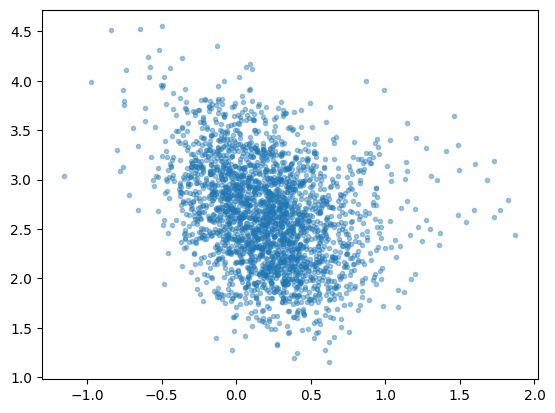

In [8]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

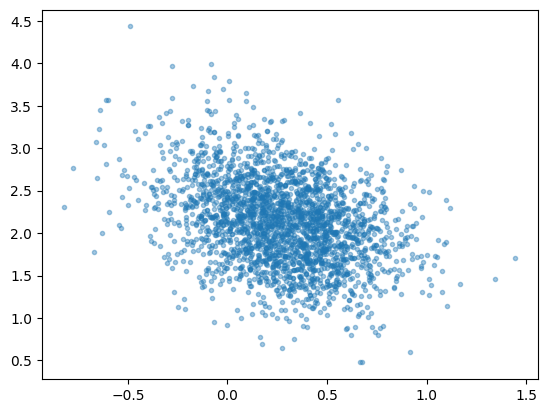

In [9]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [10]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(131.33119, dtype=float32)

In [11]:
results_dict["is_eval"]

[134.73397827148438,
 136.7855987548828,
 135.38998413085938,
 127.9640121459961,
 133.2911834716797,
 126.05553436279297,
 129.56088256835938,
 123.1683349609375,
 121.66983032226562,
 133.58831787109375,
 140.13214111328125,
 113.49324035644531,
 129.93614196777344,
 130.96810913085938,
 134.20289611816406,
 129.50120544433594,
 129.70596313476562,
 133.52984619140625,
 132.3841552734375,
 130.95095825195312,
 132.23495483398438,
 138.23724365234375,
 131.303466796875,
 131.6307373046875,
 132.9652557373047,
 129.81822204589844,
 140.5762939453125,
 130.8871612548828,
 134.3403778076172,
 130.9293212890625]

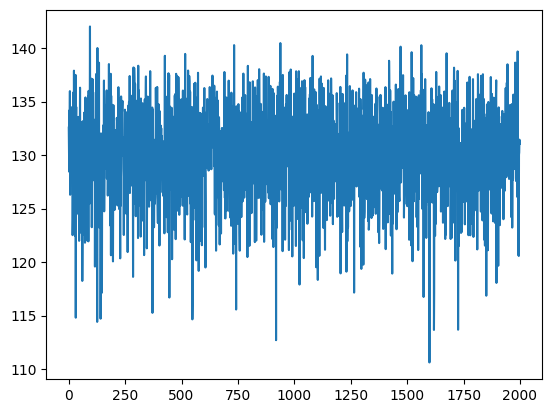

In [12]:
plt.plot(results_dict["is"])

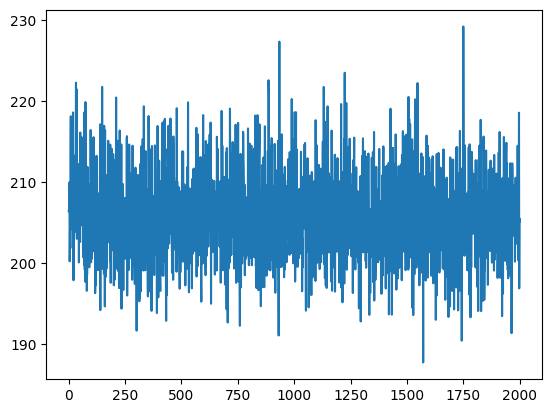

In [13]:
plt.plot(results_dict["elbo"])

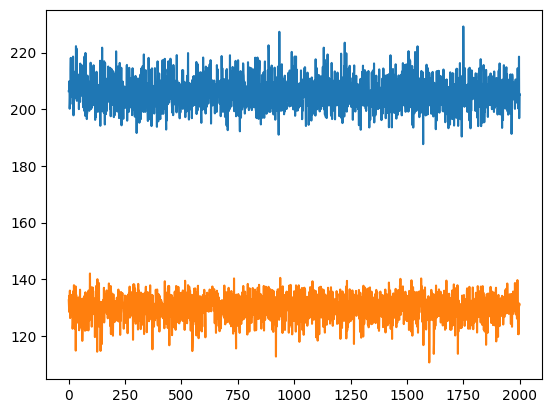

In [14]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])

In [15]:
jnp.array(results_dict["elbo_eval"]).mean()

DeviceArray(204.24199, dtype=float32)